# **Project Five - Cherry Leaves ML Pipeline**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---


## Workflow

- Data Collection
- Data Cleaning
- Data Preprocessing
- Create Pipeline
- Create Neural Network
- Fit Pipeline
- Fit Model
- Evaluate Model
- Predict Live Data

---

## Import list:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
!pip install tensorflow

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/P-Five-Mildew/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/P-Five-Mildew'

---

# Data Collection

Section 1 content

There is a data set provided by the customer, it contains 2104 images of healthy cherry leaves and 2104 images of cherry leaves containing powdery mildew.
The dataset will be accessed and downloaded from kaggle. (Insert a link here later)


In [5]:
# Install Kaggle Package
!pip install kaggle

I need to change the Kaggle configuration directory to the current working directory and set permissions for the Kaggle authentication JSON.


In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

Now that I have changed the kaggle configuration directory to the current working directory I can download the dataset and use it within Jupyter notebooks.

In [7]:
KaggleDatasetPath = "codeinstitute/cherry-leaves"
DestinationFolder = "inputs/cherry_leaves_dataset"
! kaggle datasets download -d {KaggleDatasetPath} -p {DestinationFolder}

Dataset URL: https://www.kaggle.com/datasets/codeinstitute/cherry-leaves
License(s): unknown
  0%|                                               | 0.00/55.0M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 55.0M/55.0M [00:00<00:00, 1.03GB/s]


Now I need to extract the file from the zip file:

In [8]:
import zipfile
with zipfile.ZipFile(DestinationFolder + '/cherry-leaves.zip', 'r') as zip_ref:
    zip_ref.extractall(DestinationFolder)

os.remove(DestinationFolder + '/cherry-leaves.zip')

### Load and Explore the files

In [9]:
# List top level content:
print(os.listdir(DestinationFolder))

['cherry-leaves']


I will now access both the 'healthy' and 'powdery_mildew' folders to see what is inside.

In [10]:
# Check what subfolders exsit:
print(os.listdir(os.path.join(DestinationFolder, 'cherry-leaves')))

['healthy', 'powdery_mildew']


In [11]:
# Parent Folder
cherry_leaves_path = os.path.join(DestinationFolder, 'cherry-leaves')
print(os.listdir(cherry_leaves_path))

['healthy', 'powdery_mildew']


#### Check size of dataset

I know already the dataset is made up of 2104 healthy images and 2104 powdery_mildew images, but I will check this to make sure it is correct.

In [12]:
for category in os.listdir(cherry_leaves_path):
    category_path = os.path.join(cherry_leaves_path, category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f'{category}: {num_images} images')

healthy: 2104 images
powdery_mildew: 2104 images


(256, 256)
{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


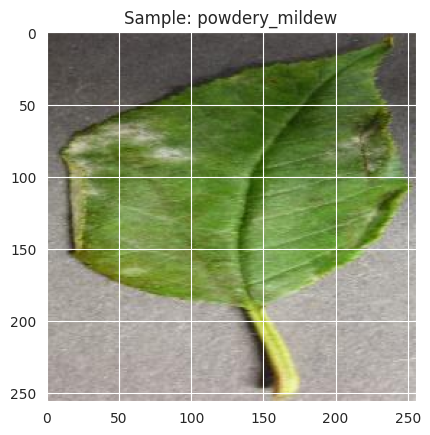

In [13]:
from PIL import Image

# Set category as either 'healthy' or 'powdery_mildew'
image_class = 'powdery_mildew'
image_fodler = os.path.join(cherry_leaves_path, image_class)

# Set counter to integer between 0 and 2103
counter = 12

# Get one image
image_file = os.listdir(image_fodler)[counter]
image_path = os.path.join(image_fodler, image_file)

# Display the image
current_image = Image.open(image_path)
plt.imshow(current_image)
plt.title(f'Sample: {image_class}')

#Check the size of the image
print(current_image.size)
print(current_image.info)


### Check image size of all files:

If all image files are the same size this is acceptable, if not then they will need to be rescaled.

##### Create function to return list of class labels

In [14]:
def return_labels(root_dir):
    label_paths = []
    # Create a loop to loop through each class (Healthy, Powdery_Mildew) and return a list
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if os.path.isdir(label_path):
            label_paths.append(label_path)
    return label_paths

In [15]:
# Create an empty set to store a unique image size
# Sets will automatically ignore duplicates, so if the only size is 256x256 then it will only store it once.

label_paths = return_labels(cherry_leaves_path)


def check_image_size(label_dir):
    sizes = set()
    # Create a loop to loop through each class (Healthy, Powdery_Mildew)
    for label_path in label_dir:
        # Loops through each filename inside current class/category
        for file in os.listdir(label_path):
            # Build path to image file
            file_path = os.path.join(label_path, file)
            # Open image using PIL Image and add to sizes object
            with Image.open(file_path) as img:
                sizes.add(img.size)

    print(f"Unique Image Sizes: {sizes}")

check_image_size(label_paths)

Unique Image Sizes: {(256, 256)}


The imagesize is 256x256, this will be acceptable however checking through the handbook notes, 
this will lead to a model larger than 100Mb, therefore resizing the images to 100x100 will allow for a 
smaller trained model. 

In [16]:
# Resize all images to 100x100
# Loop through all images and save their size as 100x100
for label_path in label_paths:
    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)
        with Image.open(file_path) as img:
            resized = img.resize((100, 100))
            # Overwrites original size
            resized.save(file_path)

Unique Image Sizes: {(100, 100)}
(100, 100)


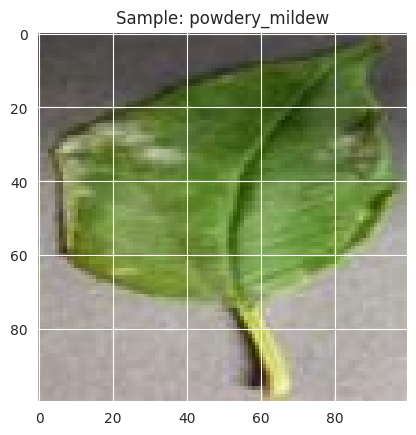

In [17]:
# Check image size:
check_image_size(label_paths)

# Display the same image from before
current_image = Image.open(image_path)
plt.imshow(current_image)
plt.title(f'Sample: {image_class}')
print(current_image.size)

---

### Convert Dataset Into Pandas Series

Before being able to create my Train, Validation and Test sets I will need the data to be in an appropriate format to be able to split the datasets. I will need to convert the datasets into a pandas series allowing the file paths to be associated with a class label.

Create reusable functions to stop repeating code:

In [18]:
def get_image_paths_and_labels(cherry_dir):
    """Return a list of iamge path and class label from subdirectories"""
    # Store each image path with its class label
    dataset = []

    # Create a for loop to loop through all files and add a class label
    for label in os.listdir(cherry_dir):
        label_path = os.path.join(cherry_dir, label)

        # Check to make sure it is a directory 
        if os.path.join(label_path):

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Append a tuple of, filepath, class label to list.
                dataset.append((img_path, label))
    dataset = pd.DataFrame(dataset, columns=['image_path', 'label'])
    return dataset


In [19]:
# Check to see if function is working correctly
cherry_df = get_image_paths_and_labels(cherry_leaves_path)
print(cherry_df)
print(cherry_df.shape)

                                             image_path           label
0     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
1     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
2     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
3     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
4     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
...                                                 ...             ...
4203  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4204  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4205  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4206  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4207  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew

[4208 rows x 2 columns]
(4208, 2)


---

### Image Montage

From the previous function it is concluded that the only unique image size is 256x256, therefore reshaping and resizing the data is not needed.

The client has asked for an image montage of the data, this will display a grid of images per class. In this case, "healthy" and "powdery_mildew".

In [20]:
# Image Montage Code

# Create sample of healthy cherry leaves
sample_healthy_df = cherry_df[cherry_df['label'] == 'healthy'].sample(16, random_state=25)

# Create sample of unhealthy cherry leaves
sample_mildew_df = cherry_df[cherry_df['label'] == 'powdery_mildew'].sample(16, random_state=25)

def image_montage(sample_df, nrows, ncols, figsize=(20,20), title='Image Montage'):
    num_slots = nrows * ncols
    num_images = len(sample_df)
    
    if num_images > num_slots:
        raise ValueError(f"There are too many images for the montage grid: {num_images} images for only {num_slots} slots."
                "Reduce sample size or increase nrows/ncols.")

    if num_images < num_slots:
        raise ValueError(f"There aren't enough images for the montage grid: {num_images} images for only {num_slots} slots."
                "Increase sample size or decrease nrows/ncols.")

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i in range(len(sample_df)):
        # Access the row by index
        row = sample_df.iloc[i]
        # Get the corresponding subpot
        ax = axes[i]

        # Open and display image
        img = Image.open(row['image_path'])
        ax.imshow(img)
        ax.set_title(row['label'], fontsize=8)
        ax.axis('off')

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()



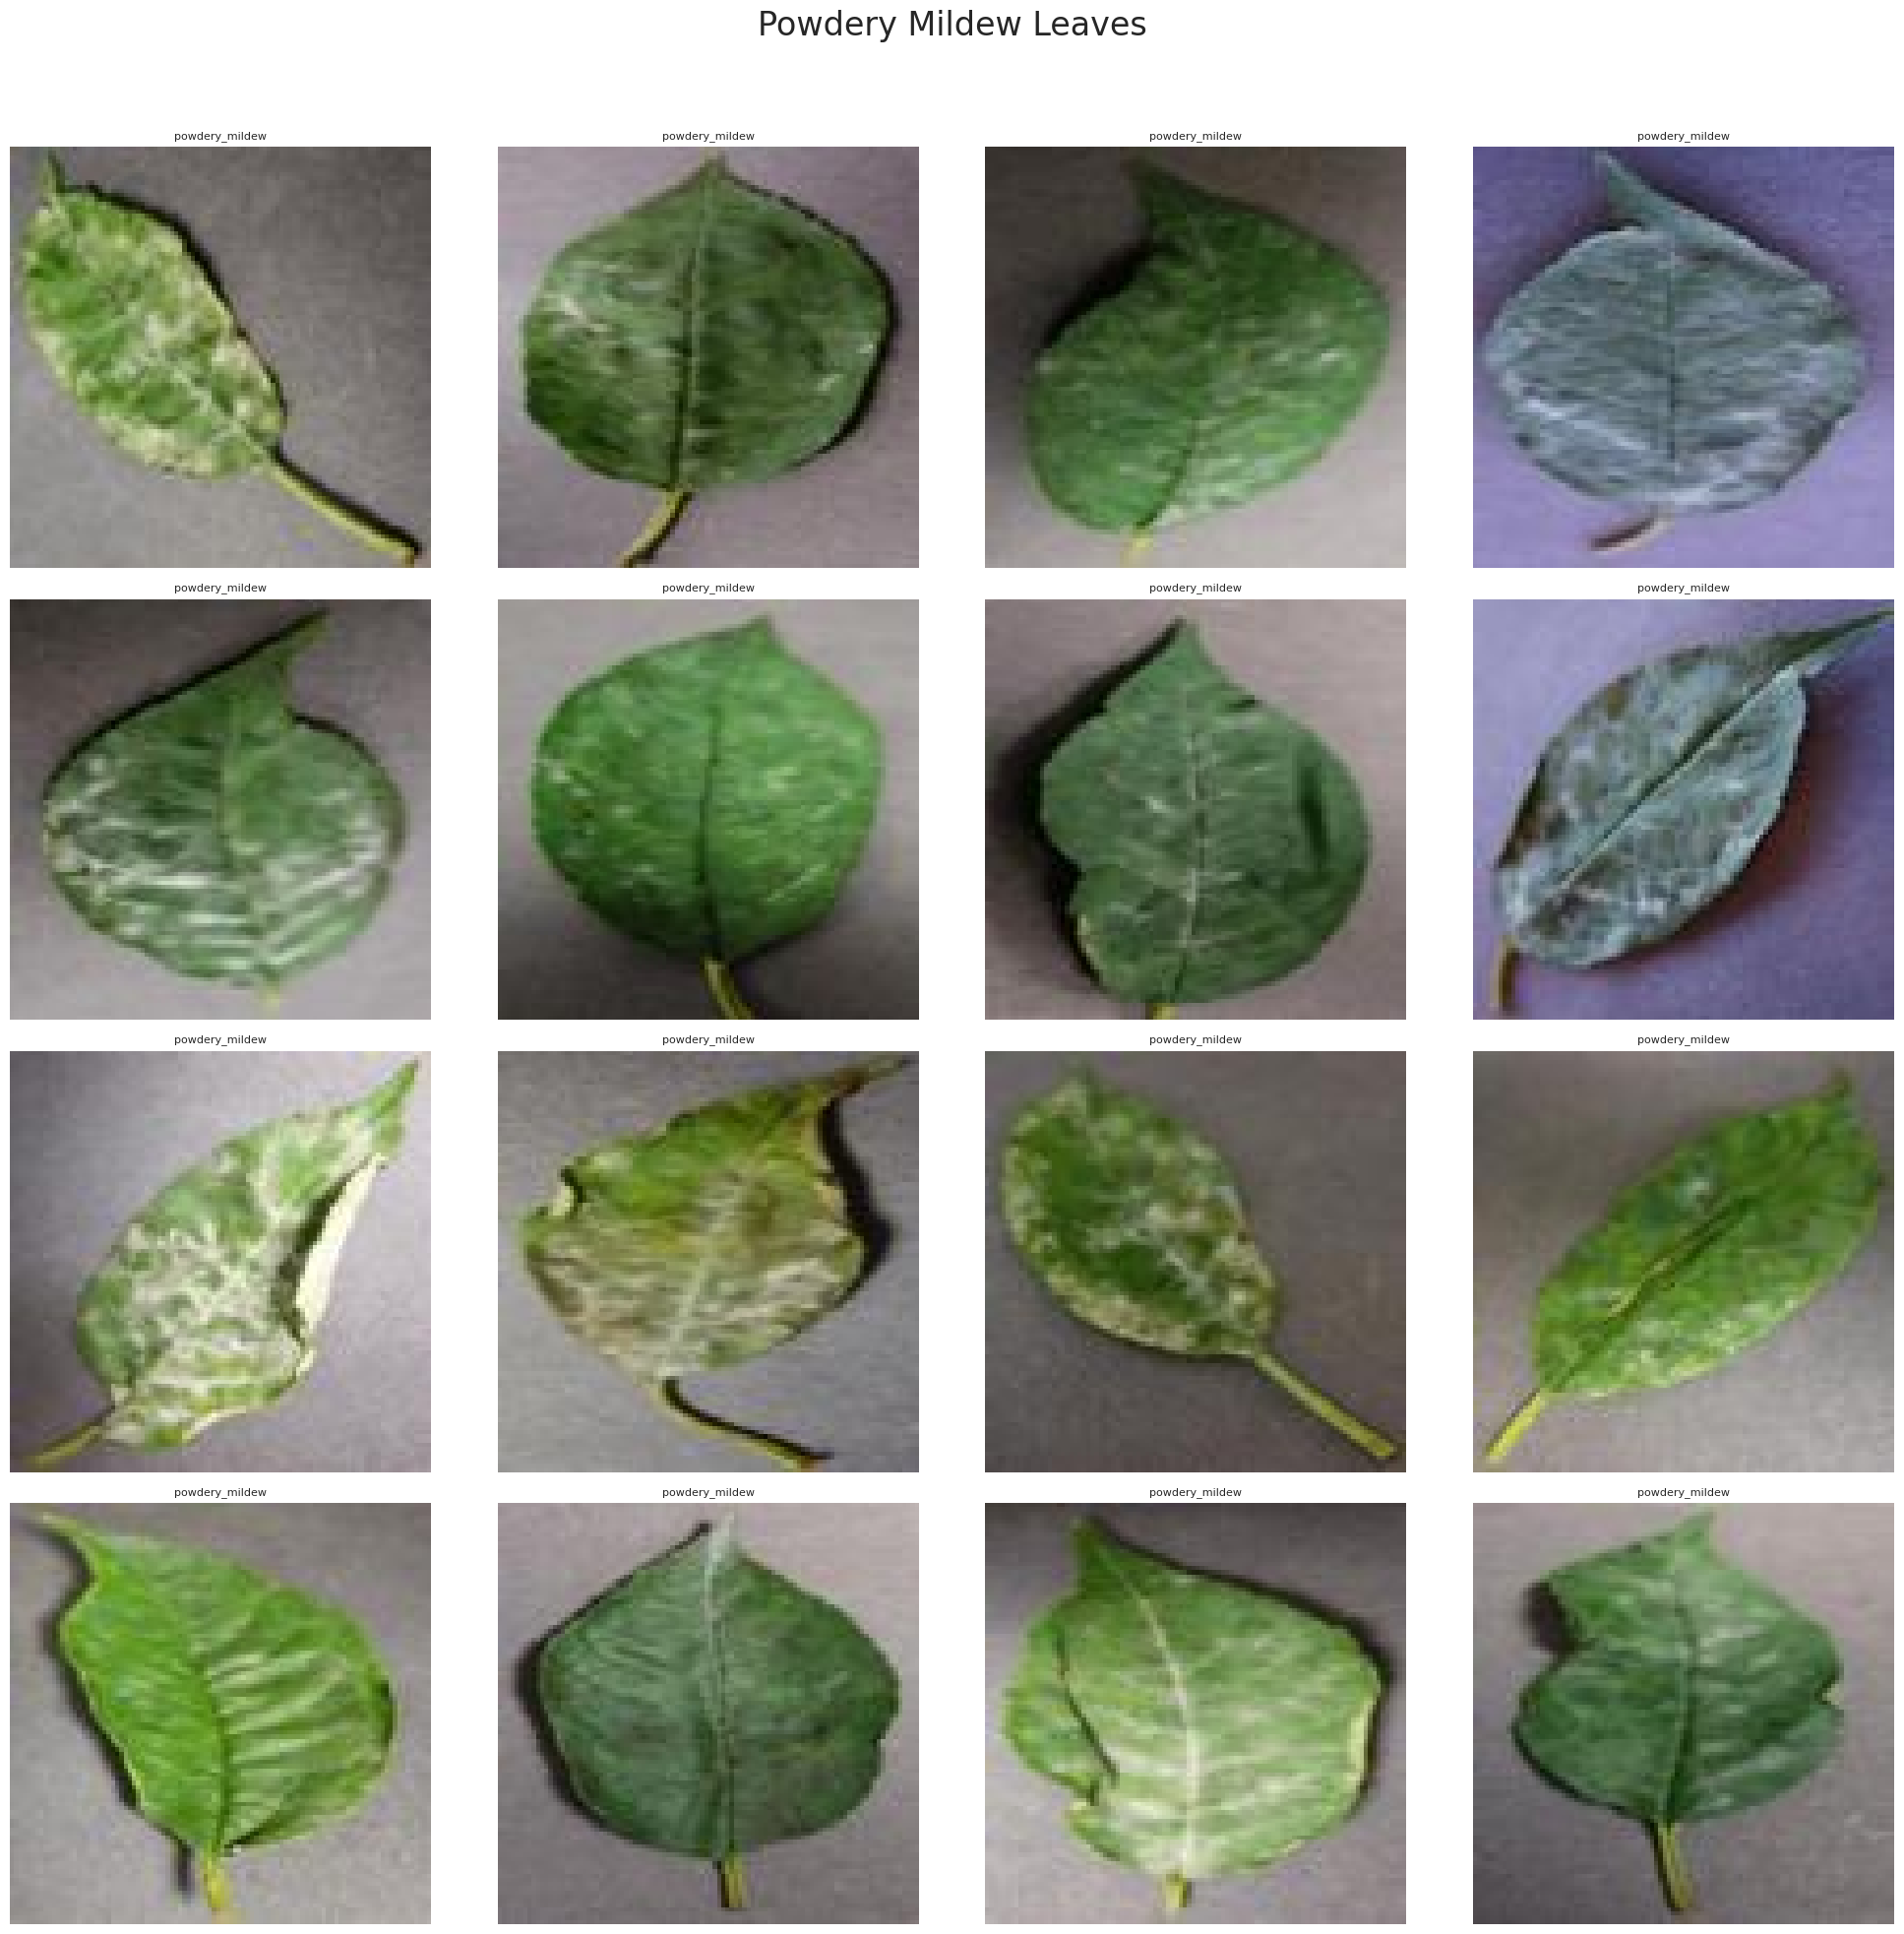

In [21]:
image_montage(sample_mildew_df, 4, 4, title='Powdery Mildew Leaves')

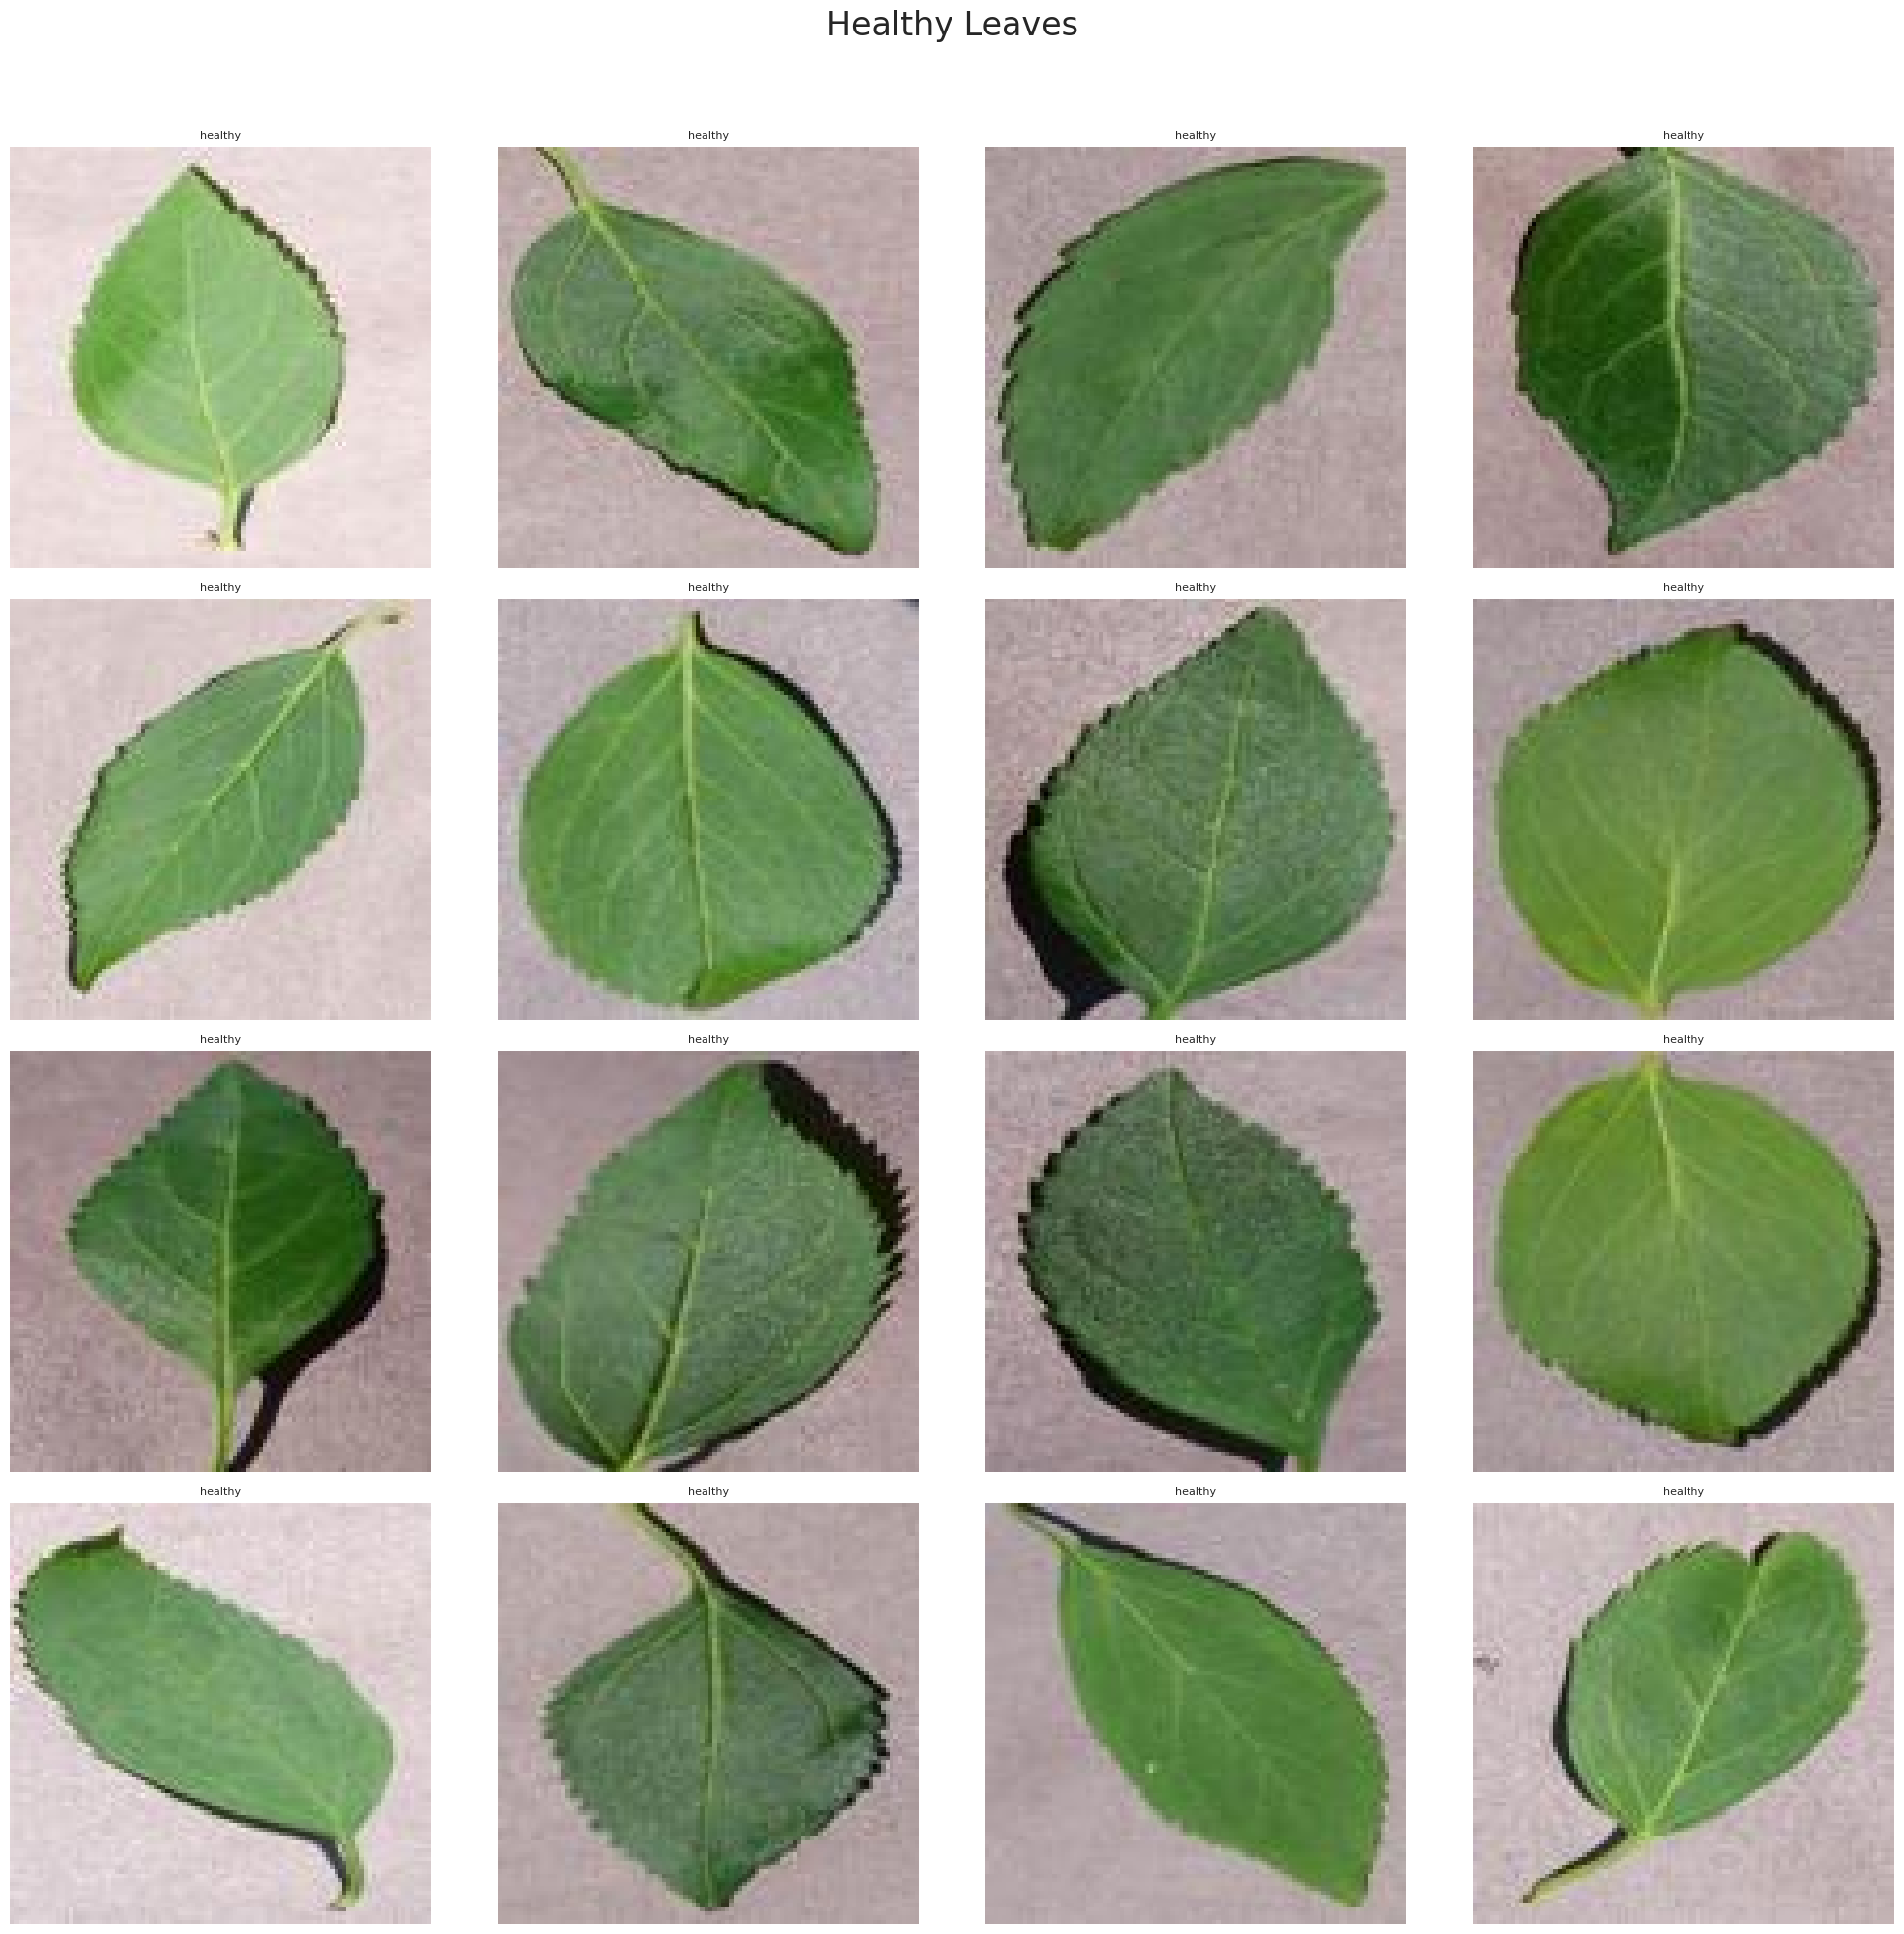

In [22]:
image_montage(sample_healthy_df, 4, 4, title='Healthy Leaves')

---

### Train, Validation, Test Set

The data structure is made up of the parent folder: Cherry leaves with two subset folders: Healthy and Mildew. I will need to restructure the file layout and create a Train, Validation and Test set so data anaylsis can be performed.


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                cherry_df.drop(['label'], axis=1),
                                cherry_df['label'],
                                test_size=0.2,
                                random_state=25
                                )

X_train, X_val, y_train, y_val = train_test_split(
                                X_train,
                                y_train,
                                test_size=0.2,
                                random_state=25
)

print("Train Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (2692, 1) (2692,)
Validation Set: (674, 1) (674,)
Test Set: (842, 1) (842,)


---

### Data Processing

In [24]:
# Scaling the data

target_classes = np.unique(y_train)
print(target_classes)
num_labels = len(target_classes)
print(num_labels)

['healthy' 'powdery_mildew']
2


After checking the unique target classes it is confirmed that 'healthy' and 'powdery_mildew' are the only 2 unique target classes.
Using .len to check, we know that we have only 2 target classes and will require a binary classification model. 

In [25]:
# Inspecting first 10 rows of y_train
y_train[:10]

3875    powdery_mildew
681            healthy
3905    powdery_mildew
2761    powdery_mildew
397            healthy
2569    powdery_mildew
3216    powdery_mildew
1614           healthy
1072           healthy
475            healthy
Name: label, dtype: object

#### Import tensorflow and keras.utils

In [26]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

2025-06-02 12:56:09.299993: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using LabelEncoder(), I am converting all my string labels/classes into integers across all sets.

In [27]:
# Encode labels to integers

# Create label encoder to keep consistency
label_encoder = LabelEncoder()

# Create encoded versions of labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

Check encoded classes to see what class is mapped to [0] and [1]:
- [0] = 'healthy'
- [1] = 'powdery_mildew'

In [28]:
print(label_encoder.classes_)

['healthy' 'powdery_mildew']


I then use to_categorical() to one hot encode for the future tensorflow model.

In [29]:
# One hot encode if wanting to create 'softmax' model
y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

---

#### Scaling and Normalising the Data

The image needs to be rescaled, since algorithms will understand and perform better when learning from a dataset that has a range from 0 - 1. Since the max value of pixels is 255, the image will be divided by 255.0 so that any range will be from 0 - 1.

In [30]:
# Check if image needs to be divided by 255

pointer = 310

image_sample = X_train['image_path'].iloc[pointer]
print(image_sample)

load_sample = tf.io.read_file(image_sample)
load_sample = tf.image.decode_jpeg(load_sample, channels=3)

print('Data Type:', load_sample.dtype)
print('Min Pixel Value:', tf.reduce_min(load_sample).numpy())
print('Max Pixel Value:', tf.reduce_max(load_sample).numpy())


inputs/cherry_leaves_dataset/cherry-leaves/powdery_mildew/119ee0ba-5aec-455d-9ce7-cfc7dae1b39d___FREC_Pwd.M 4542_flipLR.JPG
Data Type: <dtype: 'uint8'>
Min Pixel Value: 0
Max Pixel Value: 232


The image dtype is 'uint8' which means the pixel values are between 0 and 255, this is supported by the fact when checking the min and max pixel values, the values fall between 0 and 255.

The image paths can now be loaded, normalised and loaded for the pipeline.

In [31]:
# Process image_path label 
img_size = (100, 100)

def preprocess_image(image_path, label):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) #RBG 
    # Resize and normalise
    image = tf.image.resize(image, img_size) / 255.0
    return image, label


---

In [44]:
# Building a Tensorflow Dataset Object

# Convert column 'image_path' into a tensor for each train, test and val set.
X_train_tensor = tf.constant(X_train['image_path'].values)
X_val_tensor = tf.constant(X_val['image_path'].values)
X_test_tensor = tf.constant(X_test['image_path'].values)

AUTOTUNE = tf.data.AUTOTUNE

# Convert these into tf datasets
# .map the preprocess_image function above, .shuffle() by len of train dataset
X_train_ds = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_encoded)).map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(len(X_train_tensor), seed=25).batch(64).prefetch(buffer_size=AUTOTUNE)
X_val_ds = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_encoded)).map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().batch(64).prefetch(buffer_size=AUTOTUNE)
X_test_ds = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_encoded)).map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().batch(64).prefetch(buffer_size=AUTOTUNE)


Notes: From Tensorflow Documentation

Dataset.cache() - "keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache."

Dataset.prefetch() - "overlaps data preprocessing and model execution while training."

---


# Creating the Model

In [33]:
# Check shape of a batch of X_train_ds

for images, labels in X_train_ds:
    print('Image Shape:', images.shape)
    print('Labels Shape:', labels.shape)

Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)
Labels Shape: (64,)
Image Shape: (64, 100, 100, 3)


2025-06-02 12:56:12.701911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Test Model HyperParams

In [34]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [35]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

# Create a model_builder for hp tuning

def build_model(hp):
    model = Sequential()

    # Tune number of filters
    hp_filters = hp.Choice('filters', values=[16,32,64])

    model.add(Conv2D(filters=hp_filters, kernel_size=(3,3), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=hp_filters, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.25))

    if hp.Boolean('add_third_conv'):
        model.add(Conv2D(filters=hp_filters, kernel_size=(3,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.25))

    model.add(Flatten())
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])

    return model

##### Create the tuner

In [36]:
# tuner code

from keras_tuner.tuners import Hyperband
from keras.callbacks import EarlyStopping, Callback

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner = Hyperband(build_model, 
            objective='val_accuracy',
            max_epochs=10,
            factor=3,
            directory='tuner_dir',
            project_name='image_classifier',
            seed=25
        )

# class TunerProgress(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print(f"Epoch {epoch + 1} finished - Loss: {logs['loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

# tuner.search(X_train_ds, validation_data=X_val_ds, epochs=10, callbacks = [stop_early])

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# To run tuner search to find best model:
tuner.search(X_train_ds, validation_data=X_val_ds, epochs=10, callbacks = [stop_early])

Trial 30 Complete [00h 01m 36s]
val_accuracy: 0.9925816059112549

Best val_accuracy So Far: 0.998516321182251
Total elapsed time: 00h 38m 33s


### Get Best Model

I will now get the best_model recorded by the tuner and see how it performs on the X_test_ds.
- After running best_model.evaluate using the test data it returns:
- 0.0142 for loss which is very low which is what I want.
- 0.9972 for accuracy which is excellent as we want at least 97% or above for the buisness requirement.

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
# Check best model performance on test ds 
best_model.evaluate(X_test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9972 - loss: 0.0142


[0.02662786655128002, 0.9976246953010559]

In [40]:
# Save the best model in case needed for later
best_model.save('best_model.h5')

In [41]:
# Check model summary
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,673 (1.19 MB)

 Trainable params: 312,673 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# To load best model
from keras.models import load_model
best_model = load_model('best_model.h5')

### Get Best HyperParameters


I will now retrieve the hyperparameters from the model to then build the actual model, here is a list of the hyperparams:
- filters: 16
- add_third_conv: True
- units = 192
- learning_rate: 0.001
- tuner/epochs: 10
- tuner/initial_epoch: 4
- tuner/bracket: 2
- tuner/round: 2
- tuner/trial_id: 0014

In [42]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'filters': 16, 'add_third_conv': True, 'units': 192, 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


### Analyse Best Model

- Check for overfitting 
- Visualise the data

- The model has learned the data very well, which indicates the model is very effective. However because the val_accuracy is so high and there is very little fluctuation between val_loss even though it is extremely low, this might indicate the model is overfitting. I will inspect the model history next to further analyse the data.

In [43]:
history = best_model.fit(
    X_train_ds,
    epochs=10,
    validation_data=(X_val_ds)
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.9827 - loss: 0.0461 - val_accuracy: 0.9955 - val_loss: 0.0154
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 341ms/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 0.9955 - val_loss: 0.0130
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.9968 - loss: 0.0093 - val_accuracy: 0.9926 - val_loss: 0.0234
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step - accuracy: 0.9977 - loss: 0.0076 - val_accuracy: 0.9599 - val_loss: 0.0966
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 397ms/step - accuracy: 0.9977 - loss: 0.0051 - val_accuracy: 0.9970 - val_loss: 0.0077
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9970 - val_loss: 0.0050
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 323ms/step - accuracy: 0.9942 - loss: 0.0118 - val_accuracy: 0.9955 - val_loss: 0.0305
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.9957 - loss: 0.0140 - val_accur

In [37]:
# Function to plot analysis on model

def plot_model_histroy(model_history):

    plt.figure(figsize=(12,5))

    # Plot for Loss
    plt.subplot(1,2,1)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

#### Plot History

- The Model has performed very well on the validation dataset which could be a little concerning. 
- However I have already performed an evaluation on the test dataset which also gave good results which means that the model is generalising to unseen data well. 

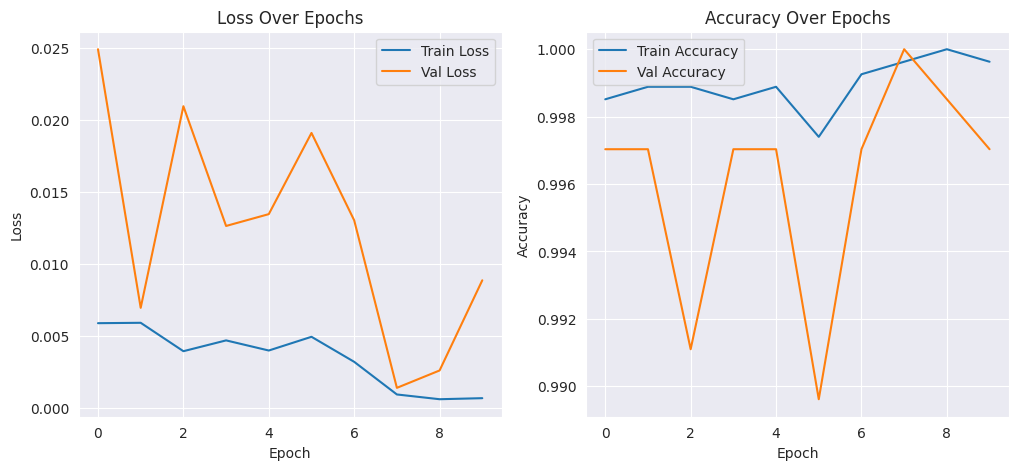

In [42]:
# Plot the model_histroy after fitting the best_model with X_train_ds and X_val_ds
plot_model_histroy(history)

Here is a table visualising the overall accuracy and loss over the 10 epochs 

In [43]:
history_model = pd.DataFrame(best_model.history.history)
history_model

,accuracy,loss,val_accuracy,val_loss
0,0.998514,0.005915,0.997033,0.024940
1,0.998886,0.005942,0.997033,0.006979
2,0.998886,0.003969,0.991098,0.020982
3,0.998514,0.004719,0.997033,0.012666
4,0.998886,0.004016,0.997033,0.013488
5,0.997400,0.004969,0.989614,0.019126
6,0.999257,0.003230,0.997033,0.013058
7,0.999629,0.000964,1.000000,0.001424
8,1.000000,0.000634,0.998516,0.002631
9,0.999629,0.000707,0.997033,0.008893


### Confusion Matrix and Classification Report


In [ ]:
# get prediction probabilities
y_pred_probs = best_model.predict(X_test_ds)
# Convert predictions to binary
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
# Retrieve true labels
y_true = y_test_encoded

In [39]:
# import confusion matrix and classifcation report

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Create classification and confusion matrix function

def create_conf_matrix_and_class_report(y_true_labels, prediciton):
    
    # Classification Report
    print('Classificaton Report:\n')
    print(classification_report(y_true_labels, prediciton))

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true_labels, prediciton)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    conf_disp.plot()

The Confustion Matrix and Classification Report results show very promising results. It achieved a 100% accuracy out of 842 samples.
- This is slightly concerning as the model might be over fitting. 
- The dataset may be too small or easily classified which might explain the high level of accuracy.

In [40]:
create_conf_matrix_and_class_report(y_true, y_pred)

NameError: name 'y_true' is not defined

### Create Final Model

In [41]:
# # Create keras model using hyper parameters from best model:

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [42]:
model = create_tf_model()
model.summary()

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,083,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,122,177 (4.28 MB)

 Trainable params: 1,122,177 (4.28 MB)

 Non-trainable params: 0 (0.00 B)

### Cross Validation Search

- I will use a Cross Validation search to train my model on different subsets, the method I will be using is the Startified K-Fold method.
- Using the Stratified K-fold method will help me confirm the consistency of its performance across the whole dataset.


In [43]:
# Stratified K-fold Method for Cross Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# x
image_paths = np.array(X_train['image_path'].values)

# y
k_fold_labels = np.array(y_train_encoded)

#Set up the K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)

# To store metric data
fold_accuracies = []

for fold, (train_index, val_index) in enumerate(skf.split(image_paths, k_fold_labels)):
    print(f'\n--- Fold {fold + 1} ---')

    #split the data
    train_paths, val_paths =  image_paths[train_index], image_paths[val_index]
    train_labels, val_labels = k_fold_labels[train_index], k_fold_labels[val_index]

    #Convert to tensors
    train_paths_tensor = tf.constant(train_paths)
    val_paths_tensors = tf.constant(val_paths)

    train_labels_tensor = tf.constant(train_labels)
    val_labels_tensors = tf.constant(val_labels)

    # Create tf.data.dataset

    k_fold_train_ds = (
        tf.data.Dataset.from_tensor_slices((train_paths_tensor, train_labels_tensor))
        .map(preprocess_image, num_parallel_calls=AUTOTUNE)
        .shuffle(len(train_paths))
        .batch(64)
        .prefetch(AUTOTUNE)
    )

    k_fold_val_ds = (
        tf.data.Dataset.from_tensor_slices((val_paths_tensors, val_labels_tensors))
        .map(preprocess_image, num_parallel_calls=AUTOTUNE)
        .batch(64)
        .prefetch(AUTOTUNE)
    )

    model = create_tf_model()

    model.fit(k_fold_train_ds, validation_data=k_fold_val_ds, epochs=5, verbose=2)

    # Evaluate using validation dataset for cross validation
    loss, accuracy = model.evaluate(k_fold_val_ds, verbose=2)
    print(f'Fold {fold + 1} Validation Accuracy: {accuracy:.4f}')
    fold_accuracies.append(accuracy)

print(f'\n Average Accuracy across folds: {np.mean(fold_accuracies):.4f}')


--- Fold 1 ---
Epoch 1/5


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-01 00:24:20.981553: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157351936 exceeds 10% of free system memory.
2025-06-01 00:24:22.166715: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157351936 exceeds 10% of free system memory.
2025-06-01 00:24:22.688252: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157351936 exceeds 10% of free system memory.
2025-06-01 00:24:23.676351: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 157351936 exceeds 10% of free system memory.
2025-06-01 00:24:24.370685: W extern

KeyboardInterrupt: 

### Check results of Cross Validation

- The results show very positive feedback, the overall average for accuracy is 0.9855 which shows the model is performing well across different splits of data.
- The model is generalising well as the differentiation between folds for accuracy is very little.
- There is a slight drop for 0.946 but this is nothing too alarming. 

In [55]:
cross_val_results_df = pd.DataFrame({
    'Fold': list(range(1, len(fold_accuracies) + 1)),
    'Validation Accuracy': fold_accuracies
})

print(cross_val_results_df)
print(f'\n Average Accuracy: {cross_val_results_df["Validation Accuracy"].mean():.4f}')

   Fold  Validation Accuracy
0     1             0.994434
1     2             0.998145
2     3             0.994424
3     4             0.994424
4     5             0.946097

 Average Accuracy: 0.9855


In [56]:
# Save results

cross_val_results_df.to_csv('cross_validation_results.csv', index=False)

### Predict Using Test Dataset

The results from predicting on the test dataset are promising. 
- It does not meet the 97% accuracy requirement, however the data will be retrained using the full train and validation sets. 
- From previous analysis I am confident the model will meet the required output of at least 97% accuracy as it is only 96% currently. 
- All healthy classes [0] were predicted correctly.
- 

In [57]:
# get prediction probabilities
model_pred_probs = model.predict(X_test_ds)
# Convert predictions to binary
model_pred = (model_pred_probs > 0.5).astype("int32").flatten()
# Retrieve true labels
y_true = y_test_encoded

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


Classificaton Report:

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       407
           1       1.00      0.92      0.96       435

    accuracy                           0.96       842
   macro avg       0.96      0.96      0.96       842
weighted avg       0.96      0.96      0.96       842



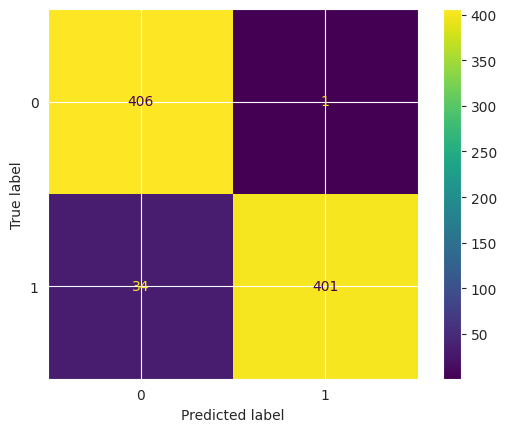

In [58]:
create_conf_matrix_and_class_report(y_true_labels=y_true, prediciton=model_pred)

---

# Final Model

### Train Model with all Train and Validation data
- The model will now be trained using all of the train set and validation set data.

In [44]:
# Create full_train_ds

# Get all image path and class labels
full_train_paths = np.concatenate([X_train['image_path'].values, X_val['image_path'].values])
full_train_labels = np.concatenate([y_train_encoded, y_val_encoded])

In [45]:
# Turn the image paths and labels into tensors
full_train_paths_tensor = tf.constant(full_train_paths)
full_train_labels_tensor = tf.constant(full_train_labels)

In [46]:
# Create full_train_ds

full_train_ds = (tf.data.Dataset.from_tensor_slices((full_train_paths_tensor, full_train_labels_tensor))
                 .map(preprocess_image, num_parallel_calls=AUTOTUNE)
                 .shuffle(len(full_train_paths))
                 .batch(64)
                 .prefetch(AUTOTUNE)
            )

Now the full length training dataset has been created, it can be fitted to the final model.

In [47]:
# Create Final Model

final_model = create_tf_model()

history = final_model.fit(full_train_ds, epochs=10, verbose=2)

Epoch 1/10
53/53 - 41s - 781ms/step - accuracy: 0.7002 - loss: 0.5535
Epoch 2/10
53/53 - 38s - 720ms/step - accuracy: 0.9418 - loss: 0.1567
Epoch 3/10
53/53 - 38s - 721ms/step - accuracy: 0.9863 - loss: 0.0522
Epoch 4/10
53/53 - 42s - 801ms/step - accuracy: 0.9887 - loss: 0.0373
Epoch 5/10
53/53 - 40s - 746ms/step - accuracy: 0.9866 - loss: 0.0381
Epoch 6/10
53/53 - 39s - 732ms/step - accuracy: 0.9970 - loss: 0.0137
Epoch 7/10
53/53 - 39s - 732ms/step - accuracy: 0.9973 - loss: 0.0110
Epoch 8/10
53/53 - 40s - 759ms/step - accuracy: 0.9976 - loss: 0.0075
Epoch 9/10
53/53 - 39s - 738ms/step - accuracy: 0.9994 - loss: 0.0054
Epoch 10/10
53/53 - 39s - 736ms/step - accuracy: 0.9982 - loss: 0.0035


In [48]:
# Convert history to DataFrame
history_df = pd.DataFrame(history.history) 

# Save as CSV file
history_df.to_csv('final_model_history')

I will next evaluate the model on the test data set.

In [49]:
final_model.evaluate(X_test_ds, verbose=2)

14/14 - 3s - 198ms/step - accuracy: 0.9846 - loss: 0.0679


[0.06789650022983551, 0.9845605492591858]

Confusion Matrix and Classification Report

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step
Classificaton Report:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       407
           1       0.97      1.00      0.99       435

    accuracy                           0.98       842
   macro avg       0.99      0.98      0.98       842
weighted avg       0.99      0.98      0.98       842



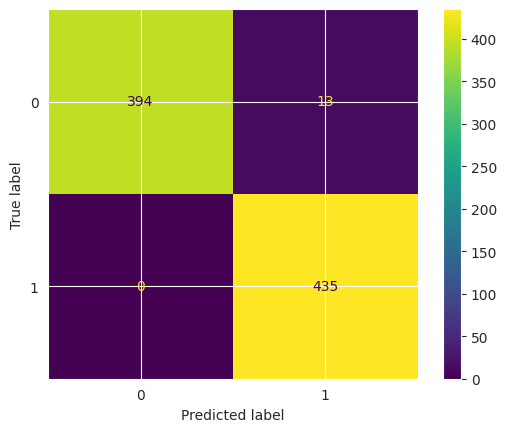

In [56]:
final_prediction = final_model.predict(X_test_ds)
final_prediction_labels = (final_prediction > 0.5).astype("int32").flatten()
create_conf_matrix_and_class_report(y_true_labels=y_true, prediciton=final_prediction_labels)

---

# Save Final Model

In [57]:
# Save final model
final_model.save('final_model.h5')

In [ ]:
# If wanting to load model later use: uncomment when needed
# from tensorflow.keras.models import load_model
# final_model = load_model("final_model.h5")


---

#### Model Summary

- The model summary above shows the current structure of the model.
- The model has a basic well defined structure currently. Originally the first Dense layer had units=128 but this resulted in total parameters of 875,777. 
- The Dense layer has now been set to 32 and the total params is at 261,185 which is more suitable for a small model like this.
- I have then adjusted the filters within the Conv2d layers, originally it was (32, 64, 64) it is now (16, 16, 32), the total number of parameters is now 109,873, and after the flatten layer the dense layer cotains 102,432. I have done this to reduce the risk of overfitting to the data. I will now fit the data to the model and evaluate its performance.

---

# Section 2

Softmax Model: version


In [ ]:
# Convert these into tf datasets for softmax
# .map the preprocess_image function above, .shuffle() by len of train dataset
X_train_ds_one = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_cat)).map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(len(X_train_tensor)).batch(64).prefetch(buffer_size=AUTOTUNE)
X_val_ds_one = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_cat)).map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
X_test_ds_one = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_cat)).map(preprocess_image, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
